In [29]:
import torch
import torch.nn as nn
import transformers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')

In [2]:
# specify GPU
# device = torch.device("cuda")

#### Load Dataset

In [3]:
df = pd.read_csv("data/spamdata_v2.csv")
df.head(2)

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...


In [4]:
df.shape

(5572, 2)

In [5]:
df['label'].value_counts(normalize = True)

0    0.865937
1    0.134063
Name: label, dtype: float64

#### Split train dataset into train, validation and test sets

In [6]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])


In [7]:
# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [8]:
print(train_text.shape, 
      temp_text.shape,
      val_text.shape,
      test_text.shape
     )

(3900,) (1672,) (836,) (836,)


#### Import BERT Model and BERT Tokenizer

In [10]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [11]:
# sample data
# text = ["this is a bert model tutorial", "we will fine-tune a bert model"]
text = ['My name is pushpendu', 
        'i work with Swasthik', 
        'my work is to build bert model', 
        'I am currently living in Bangalore but my native place is in Contai',
        'In bangalore I am living with biswajit',
        'I love coding while I am free',
        'i love coding',
        'i love'
       ]
# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [12]:
sent_id

{'input_ids': [[101, 2026, 2171, 2003, 5245, 11837, 8566, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2147, 2007, 25430, 14083, 4048, 2243, 102, 0, 0, 0, 0, 0, 0, 0], [101, 2026, 2147, 2003, 2000, 3857, 14324, 2944, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2747, 2542, 1999, 14022, 2021, 2026, 3128, 2173, 2003, 1999, 9530, 15444, 102], [101, 1999, 14022, 1045, 2572, 2542, 2007, 20377, 4213, 18902, 102, 0, 0, 0, 0, 0], [101, 1045, 2293, 16861, 2096, 1045, 2572, 2489, 102, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2293, 16861, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2293, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 

In [13]:
print(len(sent_id['input_ids'][0]))
for i in sent_id['input_ids']:
    print(i)

16
[101, 2026, 2171, 2003, 5245, 11837, 8566, 102, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 1045, 2147, 2007, 25430, 14083, 4048, 2243, 102, 0, 0, 0, 0, 0, 0, 0]
[101, 2026, 2147, 2003, 2000, 3857, 14324, 2944, 102, 0, 0, 0, 0, 0, 0, 0]
[101, 1045, 2572, 2747, 2542, 1999, 14022, 2021, 2026, 3128, 2173, 2003, 1999, 9530, 15444, 102]
[101, 1999, 14022, 1045, 2572, 2542, 2007, 20377, 4213, 18902, 102, 0, 0, 0, 0, 0]
[101, 1045, 2293, 16861, 2096, 1045, 2572, 2489, 102, 0, 0, 0, 0, 0, 0, 0]
[101, 1045, 2293, 16861, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 1045, 2293, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
for i in sent_id['attention_mask']:
    print(i)

[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Tokenization

<AxesSubplot:>

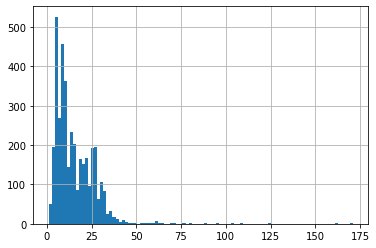

In [15]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins=100)

In [16]:
pd.DataFrame(seq_len).describe()

,0
count,3900.000000
mean,15.478462
std,11.388511
min,1.000000
25%,7.000000
50%,12.000000
75%,22.000000
max,171.000000


<AxesSubplot:>

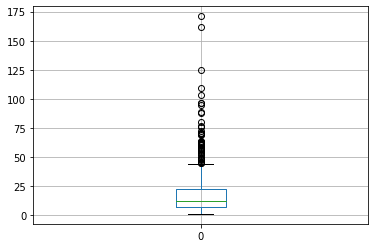

In [17]:
pd.DataFrame(seq_len).boxplot()

In [18]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\91991\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
print(tokens_train)

{'input_ids': [[101, 2035, 2097, 2272, 4142, 1012, 2488, 6149, 2151, 2204, 2559, 3275, 2045, 2993, 1012, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2061, 1043, 2094, 2288, 2489, 3256, 6949, 1012, 1012, 1012, 1045, 9808, 2080, 14071, 1012, 1012, 1012, 102, 0, 0, 0, 0, 0, 0], [101, 2024, 2017, 2746, 2000, 2154, 2005, 2465, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 14764, 1024, 2017, 2031, 2025, 22817, 1996, 4180, 2017, 2031, 2525, 3825, 2005, 1012, 2288, 2080, 8299, 1024, 1013, 1013, 9193, 2102, 1012, 102], [101, 24532, 2050, 2123, 2102, 2514, 6314, 1012, 1045, 2064, 7868, 2115, 9273, 3388, 1012, 2903, 2033, 2028, 3944, 2007, 2033, 1998, 1045, 2031, 102], [101, 10905, 1012, 1012, 1012, 2144, 2057, 2024, 2041, 2525, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 22889, 11057, 11057, 10696, 999, 2073, 2024, 2017, 1029, 2442, 1045, 18654, 2017, 2000, 2033, 2035, 1996, 2051, 2085, 1029, 2123, 1005, 1056, 102], [101, 1045, 2342, 2017, 2000, 2022, 1999, 2026, 2844, 2

#### Convert Integer Sequences to Tensors

In [20]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


In [21]:
print(train_seq)

tensor([[  101,  2035,  2097,  ...,     0,     0,     0],
        [  101,  2061,  1043,  ...,     0,     0,     0],
        [  101,  2024,  2017,  ...,     0,     0,     0],
        ...,
        [  101, 24471,  4309,  ...,  5454,  2184,   102],
        [  101,  8403,  5437,  ...,     0,     0,     0],
        [  101, 20277,  4402,  ...,     0,     0,     0]])


#### Create DataLoaders

In [22]:
# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


#### Freeze BERT Parameters

In [23]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

#### Define Model Architecture

In [44]:

class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
        super(BERT_Arch, self).__init__()

        self.bert = bert 

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768,512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [45]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# # push the model to GPU
# model = model.to(device)

In [46]:
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

#### Find Class Weights

In [47]:
#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.57743559 3.72848948]


In [48]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# # push to GPU
# weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

#### Fine-Tune BERT

In [55]:
# function to train the model
def train():
  
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

#         # push the batch to gpu
#         batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch
        
        # clear previously calculated gradients 
        model.zero_grad()        
        
#         print("sent_id, mask", sent_id, mask)
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        
        # add on to the total loss
        total_loss = total_loss + loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # update parameters
        optimizer.step()
        
        # model predictions are stored on GPU. So, push it to CPU
#         preds=preds.detach().cpu().numpy()
        preds=preds.detach().numpy()
        
        # append the model predictions
        total_preds.append(preds)
        
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds


In [58]:
# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step,batch in enumerate(val_dataloader):
    
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
#         batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()
#             preds = preds.detach().cpu().numpy()
            preds = preds.detach().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


#### Start Model Training

In [59]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model/spam_classification_fine_tuned_bert_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.324
Validation Loss: 0.423

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.333
Validation Loss: 0.164

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.191
Validation Loss: 0.384

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.261
Validation Loss: 0.143

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.207
Validation Loss: 0.145

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.228
Validation Loss: 0.140

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.218
Validation Loss: 0.129

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.222
Validat

#### Load Saved Model

In [60]:
#load weights of best model
path = 'model/spam_classification_fine_tuned_bert_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

#### Get Predictions for Test Data

In [61]:
# get predictions for test data
with torch.no_grad():
#     preds = model(test_seq.to(device), test_mask.to(device))
    preds = model(test_seq, test_mask)
#     preds = preds.detach().cpu().numpy()
    preds = preds.detach().numpy()


In [62]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       724
           1       0.80      0.96      0.87       112

    accuracy                           0.96       836
   macro avg       0.90      0.96      0.93       836
weighted avg       0.97      0.96      0.96       836



In [63]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,698,26
1,5,107
